In [1]:
import pickle
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay,
    auc
)
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    TimeSeriesSplit,
    cross_val_score,
    train_test_split,
    RandomizedSearchCV 
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.utils import resample 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.stats.outliers_influence import variance_inflation_factor


import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool

import joblib

In [2]:
# Set pandas option to display all columns
pd.set_option('display.max_columns', None)

# Loading

In [3]:
# Load the Parquet file into a DataFrame
df = pd.read_parquet('transactions_features.parquet')

# Loads dtypes
types = pd.read_csv('transactions_features_dtypes.csv', index_col=0)
types_dict = types['0'].to_dict()

In [4]:
# sets loaded dtypes to dataframe
df = df.astype(types_dict)

print(df.info())  # Display DataFrame info

<class 'pandas.core.frame.DataFrame'>
Index: 740001 entries, 530787 to 750392
Data columns (total 54 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   customerId                         740001 non-null  int64         
 1   creditLimit                        740001 non-null  int64         
 2   availableMoney                     740001 non-null  float64       
 3   transactionDateTime                740001 non-null  datetime64[ns]
 4   transactionAmount                  740001 non-null  float64       
 5   merchantName                       740001 non-null  object        
 6   acqCountry                         740001 non-null  object        
 7   merchantCountryCode                740001 non-null  object        
 8   posEntryMode                       740001 non-null  object        
 9   posConditionCode                   740001 non-null  object        
 10  merchantCategoryCode

# Sampling


The proportion of fraud cases in this dataset is relatively low, resulting in highly imbalanced data. I applied undersampling to reduce the number of observations in the majority group, achieving a 5:1 ratio between the majority and minority classes. SMOTE was not used due to concerns about introducing noise.

Moderate Balance
Ratios like 4:1 or 3:1 or 5:1 (Non-Fraudulent : Fraudulent) are often good starting points. They help reduce imbalance while retaining sufficient majority class information.

In [5]:
RAND_STATE = 42

In [6]:
df_fraud=df[df.isFraud==True] # take only fraud observations
len(df_fraud) # There are 11635 fraud cases in the dataset

11635

In [7]:
df_fraud.customerId.nunique() # 2043 unique customer have encountered fraudulent cases.

2043

In [8]:
df_nonfraud = df[df.isFraud==False] # take non fraud observations
# Undersample the majority class
df_nonfraud_downsampled = resample(
    df_nonfraud,
    replace=False,
    n_samples=len(df_fraud) * 5,  # Set the desired ratio (e.g., 1:5)
    random_state=RAND_STATE
)

In [9]:
# Combine to create a balanced dataset
df_resampled= pd.concat([df_nonfraud_downsampled, df_fraud]).sample(frac=1, random_state=RAND_STATE)

In [10]:
df_resampled.isFraud.value_counts()

isFraud
False    58175
True     11635
Name: count, dtype: int64

# Encoding

I encode categorical and boolean variables beforehand, as most models require this preprocessing step. Additionally, logistic regression requires scaling the numerical data. However, CatBoost does not require categorical variables to be encoded in advance.

### Numerical Datatype

In [11]:
# Select only numerical columns
numerical_columns = df_resampled.select_dtypes(include=['number']).columns

### Categorical Datatype

In [12]:
# Select all columns with dtype 'object' and create a list of their names
cat_columns = df_resampled.select_dtypes(include='object').columns.tolist()

# merchantName - i'm going to remove the individual locations - like AMC #010101
df_resampled["merchantName"] = df_resampled.merchantName.str.replace(r"\s#.*$", "", regex=True)

# Label-encode string and categorical features
for col in cat_columns:
    le = LabelEncoder()
    df_resampled[col] = le.fit_transform(df_resampled[col])

### Boolean Datatype

In [13]:
# Select all columns with dtype 'bool' and create a list of their names
bool_columns = df_resampled.select_dtypes(include='bool').columns.tolist()

# Processing: Convert to integers (True -> 1, False -> 0)
df_resampled[bool_columns] = df_resampled[bool_columns].astype(int)

### Time Datatype

In [14]:
# Select all columns with dtype 'bool' and create a list of their names
time_columns = df_resampled.select_dtypes(include='datetime64[ns]').columns.tolist()

In [15]:
# Sort the data by the time column
df_resampled = df_resampled.sort_values(by='transactionDateTime')

# Splitting

In [16]:
# List of columns to drop
columns_to_drop = ['isFraud','transactionDateTime', 'currentExpDate','accountOpenDate','dateOfLastAddressChange']  

# Drop the columns
X = df_resampled.drop(columns=columns_to_drop, axis=1)
y = df_resampled['isFraud']

In [17]:
# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RAND_STATE, stratify=y
)

# Model

**This analysis employs 5 methods： logistic regression, random forest, XGBoost, LightGBM, and CatBoost methods.**

**This analysis also employed stratified 5-fold cross-validation and time series split cross-validation. Random search and grid search methods were used to identify optimal parameters, and L1 or L2 regularization was applied to mitigate multicollinearity and overfitting.**

## Function and Pipline

In [18]:
# Visualize Classification Report, Confusion Matrix, ROC Curve and AUC, and Precision-Recall Curve
def model_performance(y_test, y_proba, threshold=0.5, class_names=['Negative', 'Positive']):
    
    # Ensure inputs are numpy arrays
    y_test = np.array(y_test)
    y_proba = np.array(y_proba)
    
    #  Generate predicted class labels based on the threshold
    y_pred = (y_proba >= threshold).astype(int)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.ylabel('Actual Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14)
    plt.show()
    
    #  ROC Curve and AUC
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    #  Precision-Recall Curve
    precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='purple', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curve', fontsize=14)
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()

In [19]:
#Show feature importance
def feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(18,9))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + " " +'Feature Importance',weight='bold')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

In [20]:
# Function to get feature names from ColumnTransformer
def get_feature_names(column_transformer):
    
    feature_names = []
    for name, transformer, cols in column_transformer.transformers_:
        if name == 'scaler':
            feature_names.extend(cols)
        elif name == 'onehot':
            ohe = transformer
            ohe_feature_names = ohe.get_feature_names_out(cols)
            feature_names.extend(ohe_feature_names)
    return feature_names

In [21]:
def display_top_feature_coefficients(feature_names, coefficients, top_k=10):
    
    # Create a DataFrame mapping features to their coefficients and magnitudes
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })
    
    # Sort the DataFrame by magnitude in descending order
    coef_df = coef_df.sort_values(by='Coefficient', ascending=False).reset_index(drop=True)
    
    # Display the top_k features by magnitude
    print(f"\nTop {top_k} Features by Coefficient Magnitude:")
    for i in range(top_k):
        feat_name = coef_df.loc[i, 'Feature']
        coef_val = coef_df.loc[i, 'Coefficient']
        print(f"  {i+1}. {feat_name}: Coef = {coef_val:.4f}")
    
    # Select the top_k features for plotting
    top_features = coef_df.head(top_k).copy()
    
    # Set the Seaborn style for better aesthetics
    sns.set(style="whitegrid")
    
    # Create a horizontal bar plot of the top_k feature coefficients
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=top_features, palette='viridis')
    plt.title(f'Top {top_k} Feature Coefficients Magnitude')
    plt.xlabel('Coefficient Magnitude')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    
    return coef_df.head(top_k)

## Logistic Regression with Grid Search, StratifiedKFold, and L2 Regularization

### Logistic Regression

Logistic regression assumptions:

Binary Outcome Variable:The dependent variable should be binary.

Independence of Observations: Each observation should be independent of the others. 

Linearity of Logit: Logistic regression assumes that the logit of the outcome is a linear combination of the independent variables.

No(Little) Multicollinearity: Independent variables should not be highly correlated with each other. 

Large Sample Size: Logistic regression requires a sufficiently large sample size to provide stable and reliable estimates. 

No Significant Outliers: While logistic regression is somewhat robust to outliers, extreme values can still influence the model disproportionately.



### Grid Search

I primarily use grid search to select the optimal regularization strength and optimal L1 regularization ratio in the elasticnet mode.

### Stratified KFold

Unlike standard K-Fold, Stratified K-Fold ensures that each fold has approximately the same percentage of samples from each target class as the complete dataset.
This is particularly important for imbalanced datasets, where some classes are underrepresented.

### Regularization

 L1 regularization can shrink some coefficients to exactly zero, performing feature selection by removing less important features.

 L2 regularization shrinks the coefficients but does not set them to zero, retaining all features in the model.

 Elastic Net is a hybrid regularization method that combines both L1 and L2 penalties. It incorporates the benefits of both Lasso and Ridge regression.

This study explores the impact of using VIF to address multicollinearity and finds that it significantly reduces the model's performance. Therefore, Elastic Net is used to handle both multicollinearity and overfitting effectively.

In [22]:
# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), X.select_dtypes(include=['number']).columns),  # Scale only numerical columns
        ('passthrough', 'passthrough', X.select_dtypes(exclude=['number']).columns)  # the
         
    ]
)

# Construct the Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, solver='lbfgs'))
])

# Define the Parameter Grid for GridSearchCV
# param_grid = {
#     'clf__C': [0.01, 0.1, 1, 10, 100],       # Regularization strength
#     'clf__penalty': ['l2'],                  # Penalty type
#     'clf__solver': ['lbfgs']                 # Solver
# }

param_grid = {
    'clf__penalty': [ 'elasticnet'],
    'clf__solver': ['saga'],
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__l1_ratio': [0.2, 0.5, 0.8]  
}

# Define cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
#Define Grid Search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',          # Evaluation metric
    cv=cv_strategy,
    n_jobs=-1,                   # Utilize all CPU cores
    verbose=2                    # Verbosity mode
)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

print("\nBest Cross-Validation ROC AUC Score: {:.4f}".format(grid_search.best_score_))
print("Best Parameters:")
for param_name in sorted(grid_search.best_params_.keys()):
    print(f"  {param_name}: {grid_search.best_params_[param_name]}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best Cross-Validation ROC AUC Score: 0.7785
Best Parameters:
  clf__C: 0.1
  clf__l1_ratio: 0.8
  clf__penalty: elasticnet
  clf__solver: saga


In [24]:
#Evaluate the Best Model on the Test Set
logit_best_model = grid_search.best_estimator_
y_pred = logit_best_model.predict(X_test)
y_proba = logit_best_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

# Save the best model to disk
joblib.dump(logit_best_model, 'logit_best_model.pkl')

['logit_best_model.pkl']


Classification Report:
              precision    recall  f1-score   support

   Non Fraud       0.85      0.98      0.91     11635
       Fraud       0.61      0.14      0.23      2327

    accuracy                           0.84     13962
   macro avg       0.73      0.56      0.57     13962
weighted avg       0.81      0.84      0.80     13962



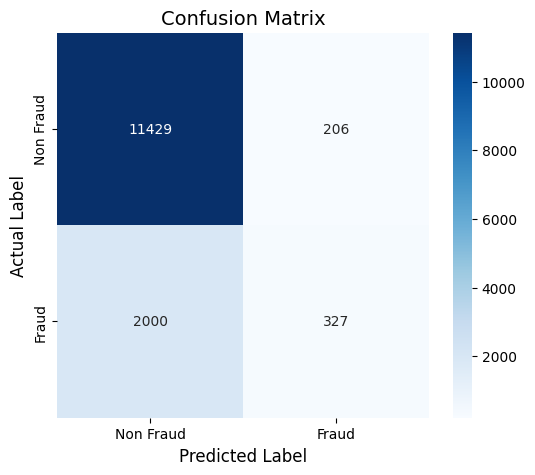

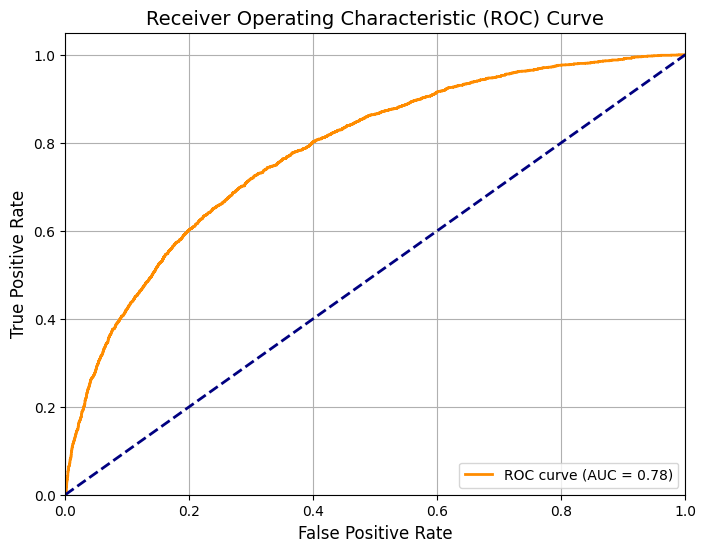

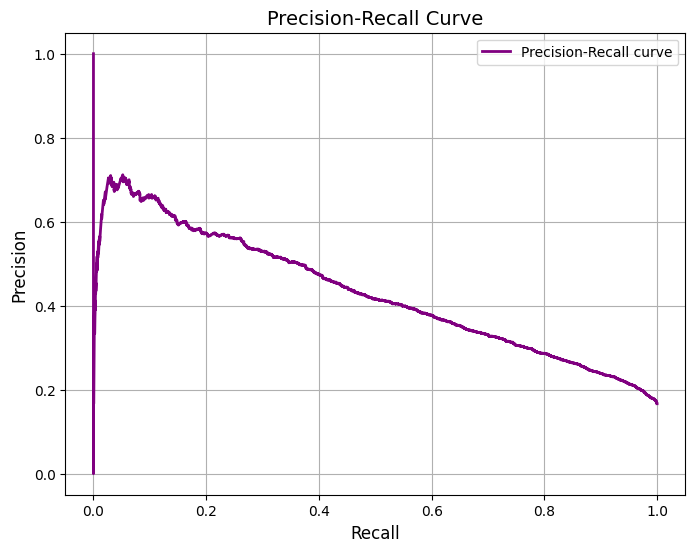

In [25]:
# Visualize model performance
model_performance(y_test, y_proba, threshold=0.5, class_names=['Non Fraud', 'Fraud'])


Top 10 Features by Coefficient Magnitude:
  1. avgFraud: Coef = 0.5664
  2. transactionAmount: Coef = 0.5233
  3. MerchantavgFraud: Coef = 0.3346
  4. merchant_transaction_count: Coef = 0.1612
  5. posEntryMode: Coef = 0.1548
  6. is_missing_flag: Coef = 0.1465
  7. acqCountry: Coef = 0.1421
  8. merchant_rolling_mean_month: Coef = 0.1307
  9. transactionType: Coef = 0.1248
  10. merchant_rolling_max_month: Coef = 0.1088


C:\Users\wangj\AppData\Local\Temp\ipykernel_23748\1106900431.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=top_features, palette='viridis')


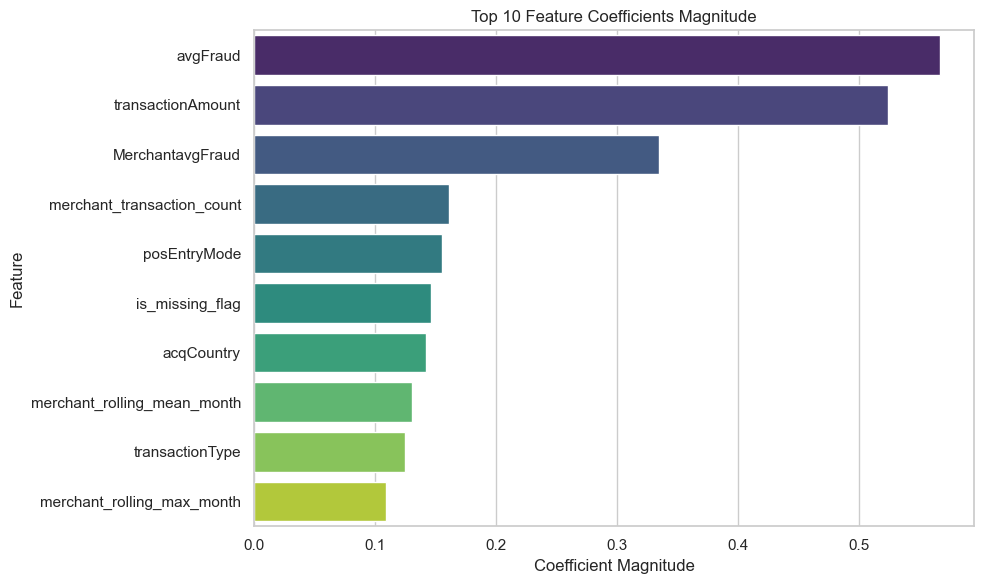

,Feature,Coefficient
0,avgFraud,0.566385
1,transactionAmount,0.523266
2,MerchantavgFraud,0.334611
3,merchant_transaction_count,0.161166
4,posEntryMode,0.154835
5,is_missing_flag,0.146472
6,acqCountry,0.142141
7,merchant_rolling_mean_month,0.130716
8,transactionType,0.124847
9,merchant_rolling_max_month,0.108844


In [26]:
# Retrieve feature names from the preprocessor
feature_names = get_feature_names(logit_best_model.named_steps['preprocessor'])

# Extract coefficients from the Logistic Regression model
coefficients = logit_best_model.named_steps['clf'].coef_[0]

#Display top features
display_top_feature_coefficients(feature_names, coefficients, top_k=10)

## Random Forest with Grid Search and Stratified 5-fold Cross-validation 

### Random Forest

Decision Trees: Random Forest consists of many decision trees. A decision tree makes predictions by splitting the data based on feature values, creating a tree-like model of decisions.

Randomness: Each tree in the forest is trained on a random subset of the training data and a random subset of the features. This randomness helps ensure that the trees are diverse and not too similar to each other.

Classification: For classification tasks, each tree in the forest votes for a class, and the class with the majority of votes is chosen as the final prediction.

Robustness: Random Forest is less prone to overfitting compared to individual decision trees because it averages multiple trees, reducing the variance in predictions.

Feature Importance: Random Forest provides insights into which features are most important in making predictions, aiding in feature selection and understanding the data.

Limits

Complexity: More complex and computationally intensive than single decision trees, making them slower to train and predict.

Interpretability: While individual trees are easy to interpret, the ensemble nature of Random Forest makes the overall model harder to understand.

In [27]:
# Define a Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

#Prepare a parameter grid for GridSearchCV
param_grid = {
    "max_depth": [5, 10],
    "n_estimators": [100, 200],
    "min_samples_split": [2, 5]
}

# Create a 5-fold cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RAND_STATE)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv_strategy,
    n_jobs=-1,      # use all available CPU cores
    verbose=1
)

In [28]:
#Fit (train) the GridSearchCV on the training data
grid_search.fit(X_train, y_train)

#Print the best parameters and best score found by GridSearchCV
print("Grid Search Complete!")
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation AUC Score:", grid_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Grid Search Complete!
Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best Cross-Validation AUC Score: 0.8309682215642351


In [29]:
#Retrieve the best model (Random Forest with the best hyperparameters)
rf_best_model = grid_search.best_estimator_

#Use the best model to predict on the test set
rf_best_model.fit(X_train, y_train)
y_pred_test = rf_best_model.predict(X_test)
y_prob_test = rf_best_model.predict_proba(X_test)[:, 1]

# Save the best model to disk
joblib.dump(rf_best_model, 'rf_best_model.pkl')

['rf_best_model.pkl']


Classification Report:
              precision    recall  f1-score   support

   Non Fraud       0.86      0.99      0.92     11635
       Fraud       0.84      0.17      0.28      2327

    accuracy                           0.86     13962
   macro avg       0.85      0.58      0.60     13962
weighted avg       0.85      0.86      0.81     13962



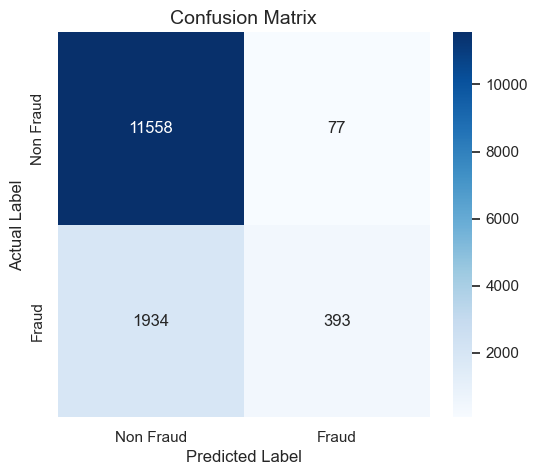

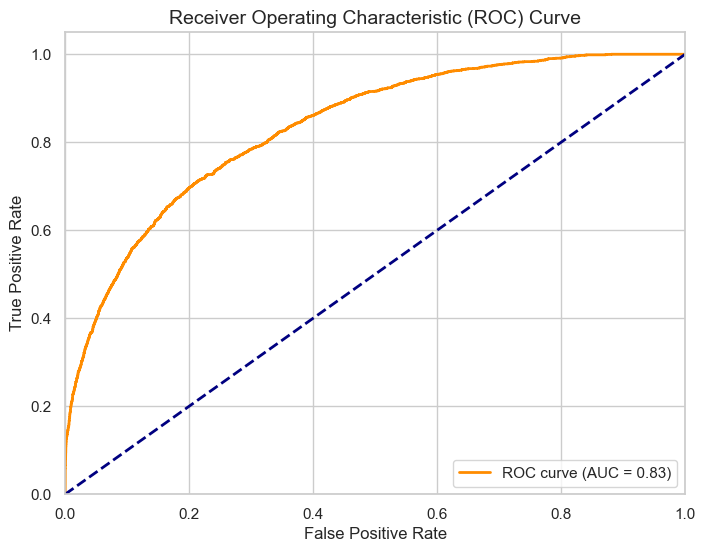

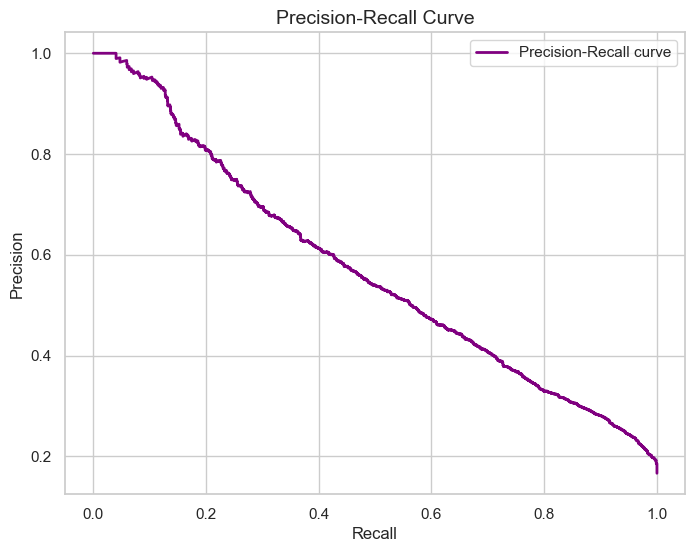

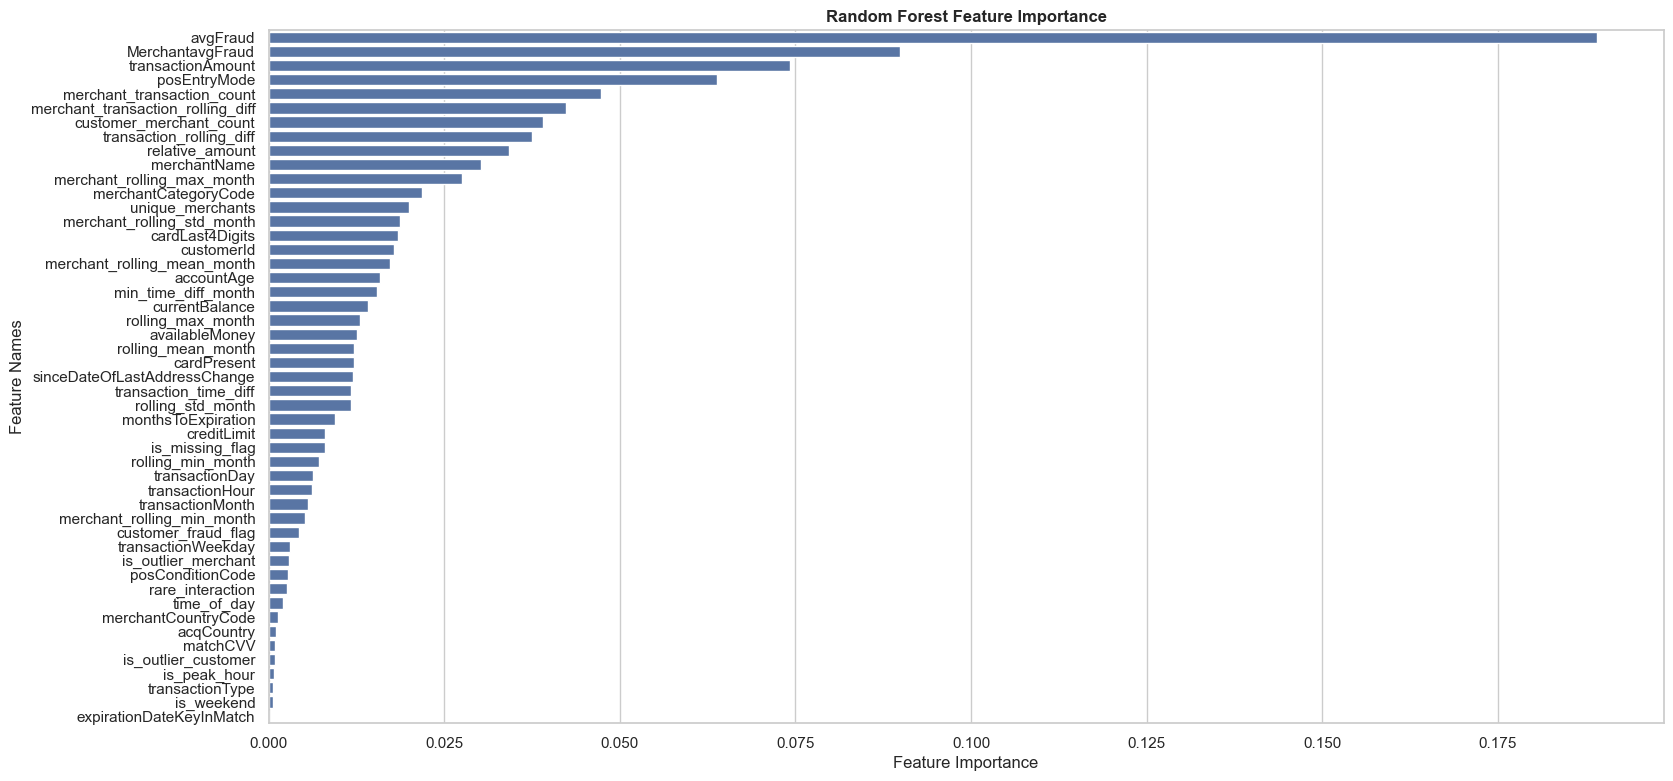

In [30]:
# Visualize model performance
model_performance(y_test, y_prob_test, threshold=0.5, class_names=['Non Fraud', 'Fraud'])
feature_importance(rf_best_model.feature_importances_,X_train.columns,'Random Forest')

## XGboost with Grid Search, Regularization and Stratified Kfold Validation

### XGboost

XGBoost is based on the gradient boosting algorithm, which builds an ensemble of weak learners in a sequential manner. Each new tree corrects the errors made by the previous ones, leading to improved predictive performance.

Unlike traditional gradient boosting, XGBoost incorporates L1 (Lasso) and L2 (Ridge) regularization terms in its objective function. This helps prevent overfitting, enhancing the model's generalization capabilities.

Parallel and Distributed Computing: Optimized for speed and performance, XGBoost supports parallel processing, allowing it to train models faster by utilizing multiple CPU cores. It also offers distributed computing capabilities, making it suitable for large-scale datasets.

Tree Pruning: Implements a depth-first approach with a maximum depth parameter to grow trees, and uses greedy algorithm with optimal split finding, ensuring efficient and effective tree construction

In [31]:
# Define a Random XGboost Classifier
xgboost = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=RAND_STATE,
    reg_alpha=0.8,  # L1 
    reg_lambda=0.2,  # L2 
)
# Create a 5-fold cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RAND_STATE)

#Prepare a parameter grid for GridSearchCV
#Limited number of grids for time concerns
parameters=  { 'max_depth': [3, 6],
    'n_estimators': [500, 1000],
    'learning_rate': [0.1, 0.01]}

# Define Grid Search
grid_search = GridSearchCV(
    estimator=xgboost,
    param_grid=parameters,
    scoring='roc_auc',
    n_jobs = 10,
    cv = cv_strategy ,
    verbose=True
)

In [32]:
#Fit (train) the GridSearchCV on the training data
grid_search.fit(X_train, y_train)

#Print the best parameters and best score found by GridSearchCV
print("Grid Search Complete!")
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation AUC Score:", grid_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Grid Search Complete!
Best Parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1000}
Best Cross-Validation AUC Score: 0.8492553791283036


In [33]:
#Retrieve the best model
xgb_best_model = grid_search.best_estimator_

#Fit the model
xgb_best_model.fit(X_train,y_train)

#Predict the model
y_preds = xgb_best_model.predict(X_test)
y_prob = xgb_best_model.predict_proba(X_test)[:, 1]

# Save the best model to disk
joblib.dump(xgb_best_model, 'xgb_best_model.pkl')

['xgb_best_model.pkl']


Classification Report:
              precision    recall  f1-score   support

   Non Fraud       0.88      0.97      0.92     11635
       Fraud       0.71      0.31      0.43      2327

    accuracy                           0.86     13962
   macro avg       0.80      0.64      0.68     13962
weighted avg       0.85      0.86      0.84     13962



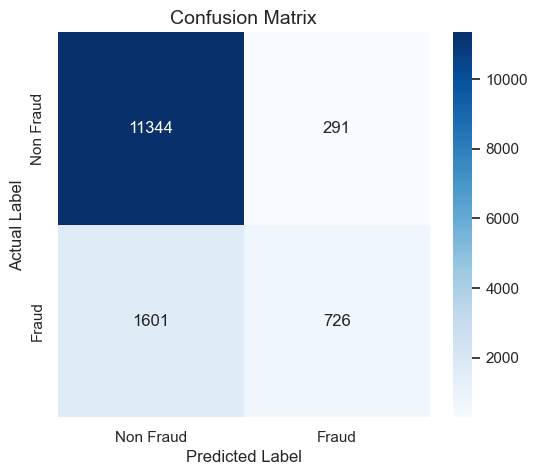

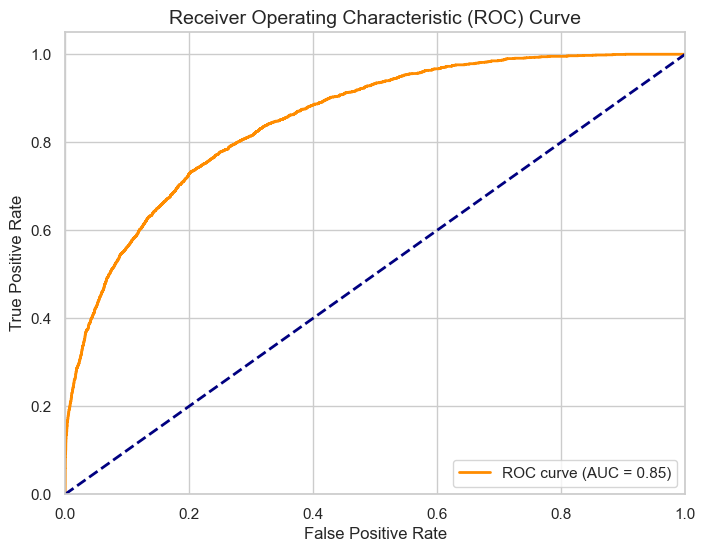

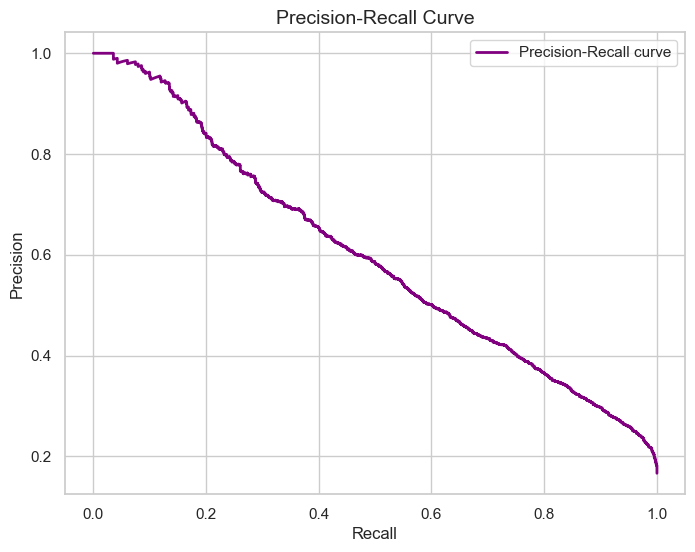

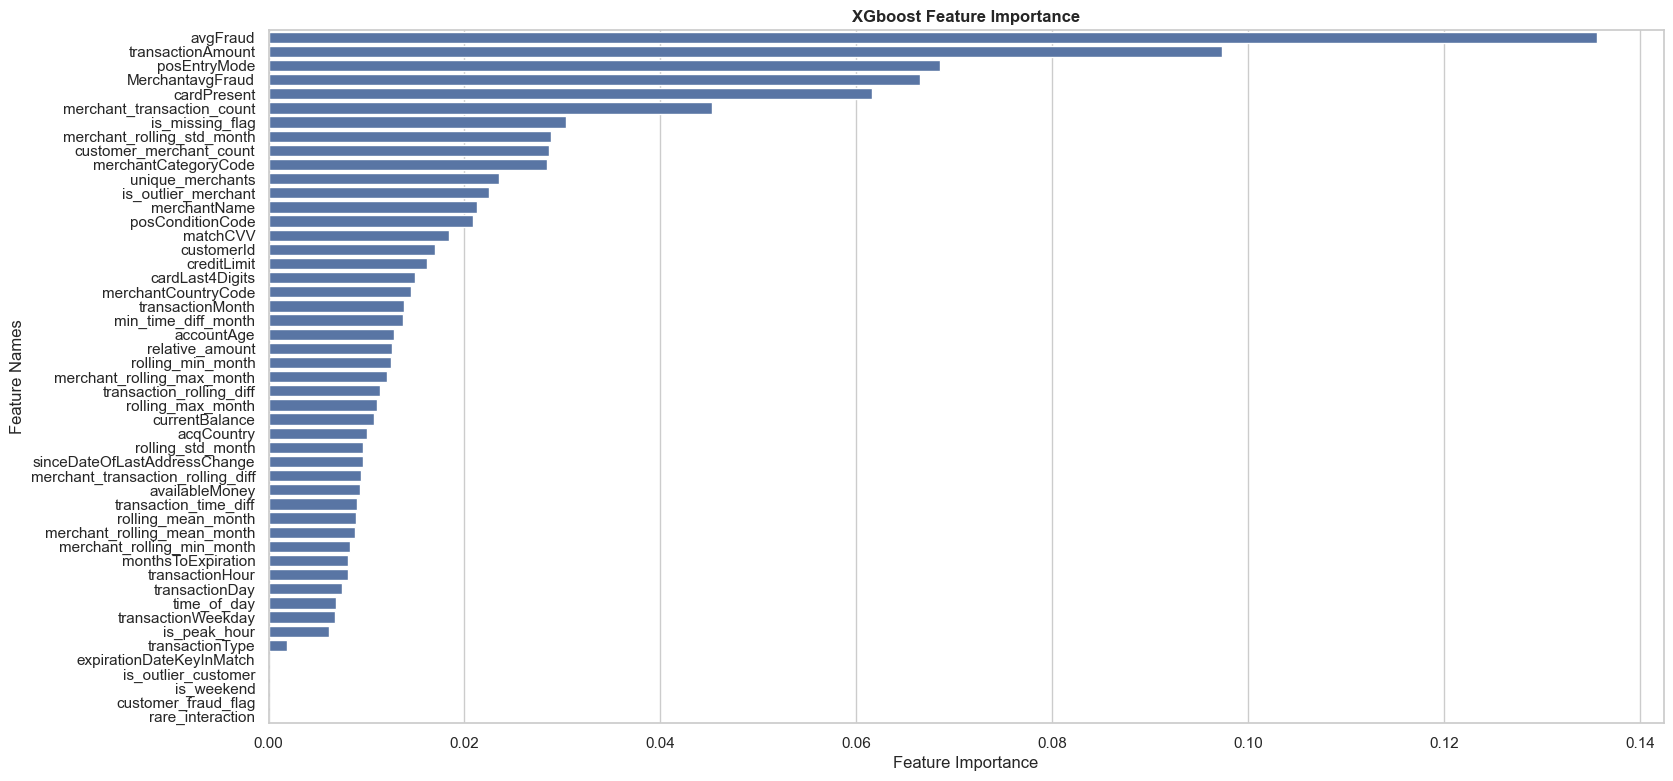

In [34]:
# Visualize model performance
model_performance(y_test, y_prob, threshold=0.5, class_names=['Non Fraud', 'Fraud'])
feature_importance(xgb_best_model.feature_importances_,X_train.columns,'XGboost')

## LightGBM with Randomized Search, Regularization and Time Series Split Validation 

### LightGBM


Histogram-Based Decision Tree Learning: LightGBM discretizes continuous feature values into discrete bins and builds decision trees based on these histograms.
This approach accelerates training and reduces memory consumption, enabling the handling of large datasets efficiently.

Support for Categorical Features: LightGBM natively handles categorical features without the need for explicit encoding. Simplifies preprocessing and preserves the inherent information in categorical variables, potentially enhancing model performance.

Parallel and GPU Learning: LightGBM supports parallel learning on CPUs and GPU acceleration. Significantly speeds up the training process, especially for large datasets and complex models.

Leaf-Wise Tree Growth: Unlike traditional depth-wise tree growth, LightGBM grows trees leaf-wise by selecting the leaf with the maximum delta loss to grow. 

### Time Series Split Cross Validation

The credit history of credit card holders and merchants is critically important for our model. To ensure the integrity of our predictions, we aim to prevent any data leakage. Data leakage could occur if the model inadvertently accesses information that has not yet occurred, leading to unrealistic performance estimates. To avoid this, we employ Time Series Split Cross Validation, which maintains the chronological order of data and ensures that the model is only trained on past information when making predictions about future events.

Time Series Split Cross Validation is a specialized cross-validation technique tailored for evaluating machine learning models on time-dependent data. Time Series Split respects the chronological order of observations, ensuring that future data points are not used to predict past events. This approach is crucial for maintaining the integrity and realism of time series forecasting and modeling tasks.  

No Shuffling: Shuffling time series data would disrupt the temporal dependencies and lead to unrealistic model evaluations, as it would allow future information to leak into the training process.

Preservation of Temporal Order: Ensures that the model is always trained on past data and tested on future data, mimicking real-world forecasting scenarios.

Prevents Look-Ahead Bias: Eliminates the risk of using future information to predict past events, ensuring unbiased performance metrics.

Disadvantages: 
Limited Data for Training: Especially in early folds, the training set may be small, potentially leading to less robust model training.

### Randomized Search

Randomized Search is a hyperparameter tuning technique used in machine learning to optimize model performance by randomly sampling from a predefined hyperparameter space. Unlike Grid Search, which evaluates all possible combinations of hyperparameter values, Randomized Search selects a subset of these combinations randomly, making it a more efficient and faster approach for hyperparameter optimization.

Disadvantages: No Guarantee of Optimality. It may not find the absolute best hyperparameter combination due to the random nature of the search.


In [36]:
# Fit RandomizedSearchCV
random_search.fit(X, y)
print("Randomized Search CV completed.")
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation AUC Score:", grid_search.best_score_)

C:\Users\wangj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=100. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Info] Number of positive: 11635, number of negative: 58175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6818
[LightGBM] [Info] Number of data points in the train set: 69810, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further 

In [37]:
# Best estimator from RandomizedSearchCV
lgbm_best_model = random_search.best_estimator_
lgbm_best_model.fit(X_train,y_train)

y_pred = lgbm_best_model.predict(X_test)
y_proba = lgbm_best_model.predict_proba(X_test)[:, 1]

# Save the best model to disk
joblib.dump(lgbm_best_model, 'lgbm_best_model.pkl')


[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Info] Number of positive: 9308, number of negative: 46540
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6819
[LightGBM] [Info] Number of data points in the train set: 55848, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

['lgbm_best_model.pkl']


Classification Report:
              precision    recall  f1-score   support

   Non Fraud       0.88      0.98      0.92     11635
       Fraud       0.72      0.32      0.44      2327

    accuracy                           0.87     13962
   macro avg       0.80      0.65      0.68     13962
weighted avg       0.85      0.87      0.84     13962



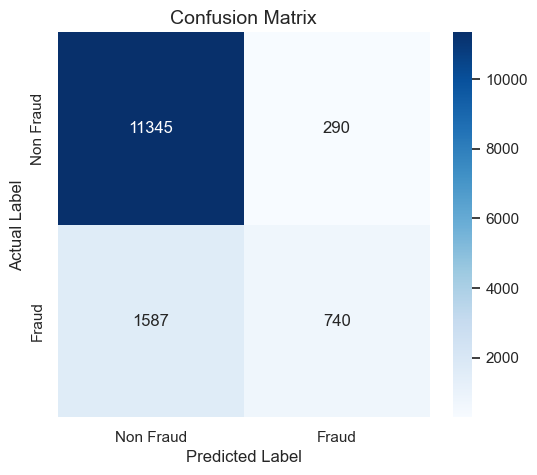

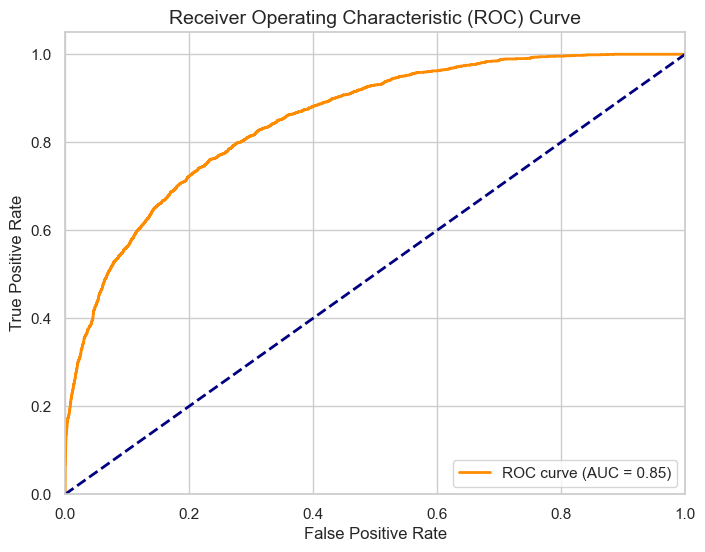

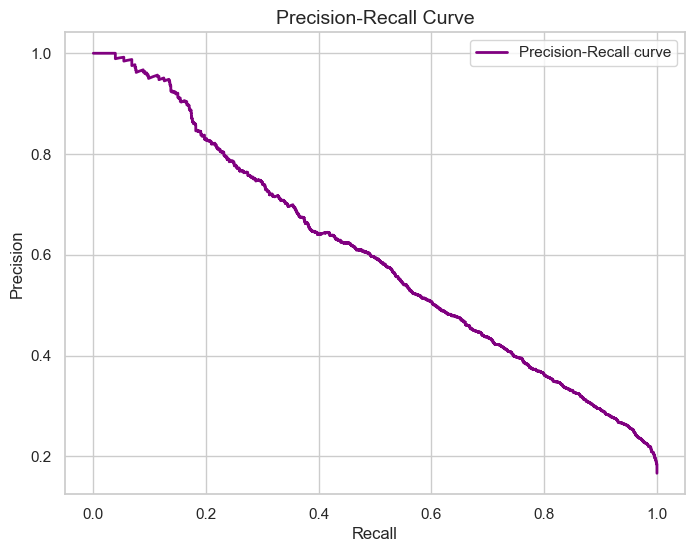

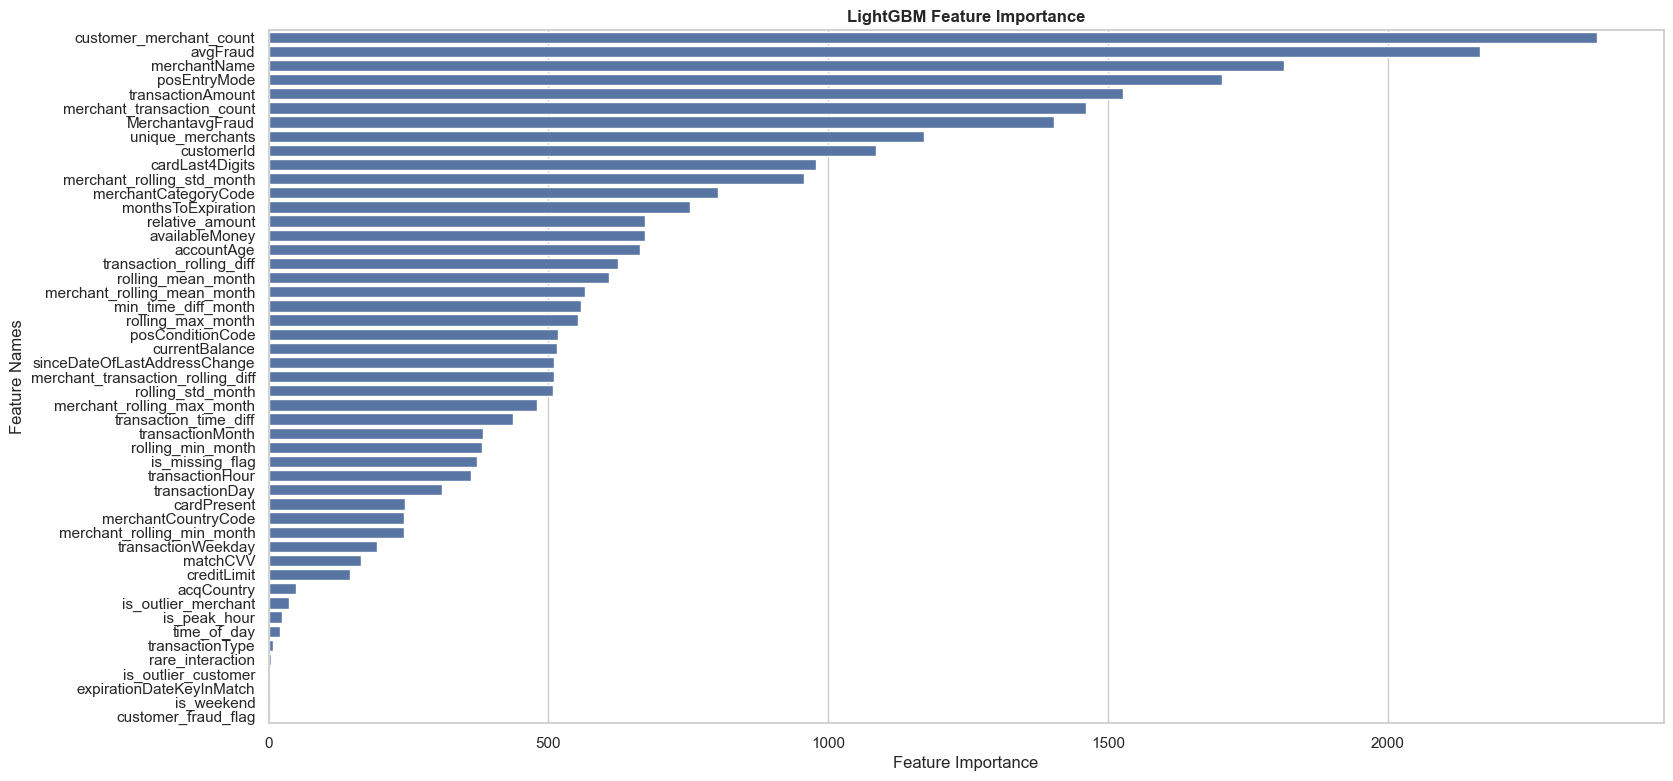

In [38]:
# Visualize model performance
model_performance(y_test, y_proba, threshold=0.5, class_names=['Non Fraud', 'Fraud'])
feature_importance(lgbm_best_model.feature_importances_,X_train.columns,'LightGBM')

## Catboost with Randomized Search, Regularization and Time Series Split

### Catboost

Handling Categorical Features Natively: Unlike many other machine learning algorithms that require extensive preprocessing (like one-hot encoding) for categorical variables, CatBoost can process categorical features directly.

Symmetric Tree Structure: Builds symmetric decision trees where splits are applied simultaneously across all trees at a given depth.

Ordered Boosting: Implements a novel boosting technique called Ordered Boosting to combat overfitting and reduce prediction shift.

Automatic Handling of Missing Values: CatBoost can automatically manage missing data without requiring imputation.

In [39]:
# Define the CatBoost classifier
catboost = CatBoostClassifier(
    verbose=0,
    random_state=RAND_STATE,
    class_weights=[1, 2],  # Example: Assign higher weight to the minority class
    depth=6,
    l2_leaf_reg=3,  # L2 
)

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'iterations': [500, 1000],
    'depth': [4, 6],
    'learning_rate': [ 0.05],
    # 'catboost__l2_leaf_reg': [1, 3, 5, 7, 9],
    # 'catboost__bagging_temperature': [0, 0.1, 0.2, 0.3],
    # 'catboost__border_count': [32, 64, 128],
    # 'catboost__random_strength': [1, 2, 3],
    # 'catboost__leaf_estimation_iterations': [1, 2, 3],
    # 'catboost__thread_count': [4, 8, 16]
}

# Define the cross-validation strategy for time series
tscv = TimeSeriesSplit(n_splits=5)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=catboost,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings sampled
    scoring='roc_auc',
    cv=tscv,
    verbose=1,
    random_state=RAND_STATE,
    n_jobs=-1
)

In [40]:
# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)
print("Randomized Search CV completed.")
print(f"\nBest Hyperparameters: {random_search.best_params_}")
print(f"Best Cross-Validation ROC AUC: {random_search.best_score_:.4f}")

C:\Users\wangj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Randomized Search CV completed.

Best Hyperparameters: {'learning_rate': 0.05, 'iterations': 500, 'depth': 6}
Best Cross-Validation ROC AUC: 0.8442


In [41]:
# Best estimator from RandomizedSearchCV
cat_best_model = random_search.best_estimator_
cat_best_model.fit(X_train,y_train)

# Predict probabilities and classes on the test set
y_proba = cat_best_model.predict_proba(X_test)[:, 1]
y_pred = cat_best_model.predict(X_test)

# Save the best model to disk
joblib.dump(cat_best_model, 'cat_best_model.pkl')

['cat_best_model.pkl']


Classification Report:
              precision    recall  f1-score   support

   Non Fraud       0.91      0.92      0.91     11635
       Fraud       0.58      0.53      0.55      2327

    accuracy                           0.86     13962
   macro avg       0.74      0.73      0.73     13962
weighted avg       0.85      0.86      0.85     13962



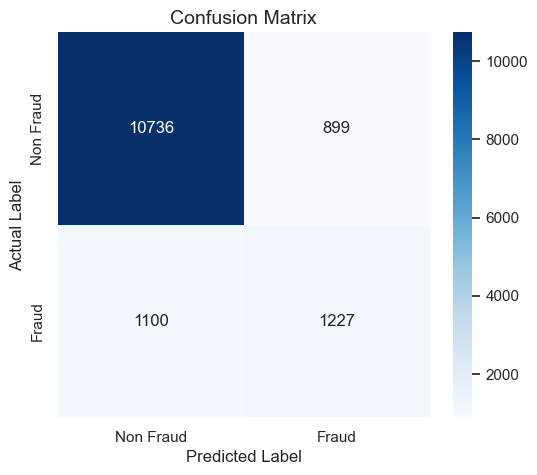

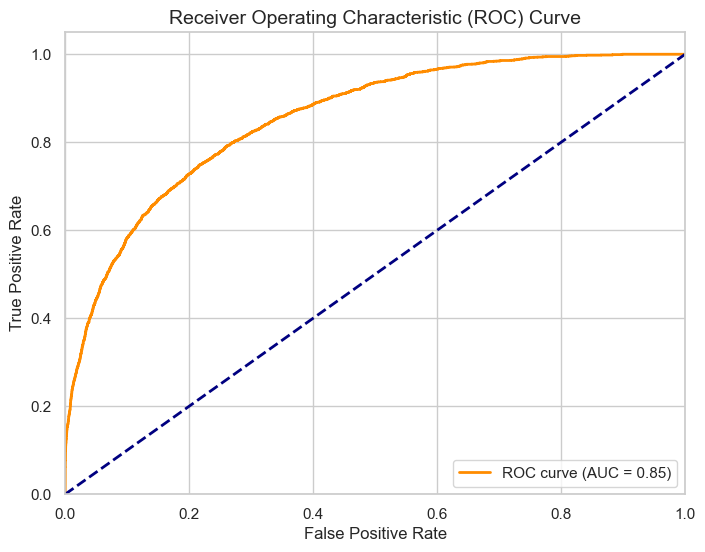

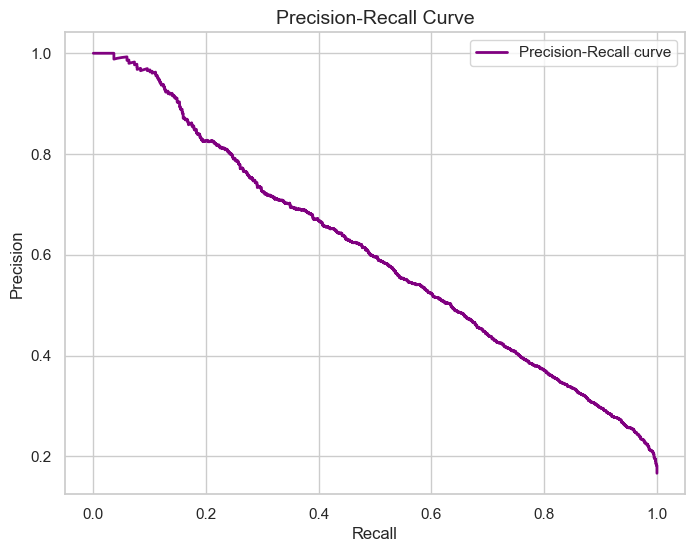

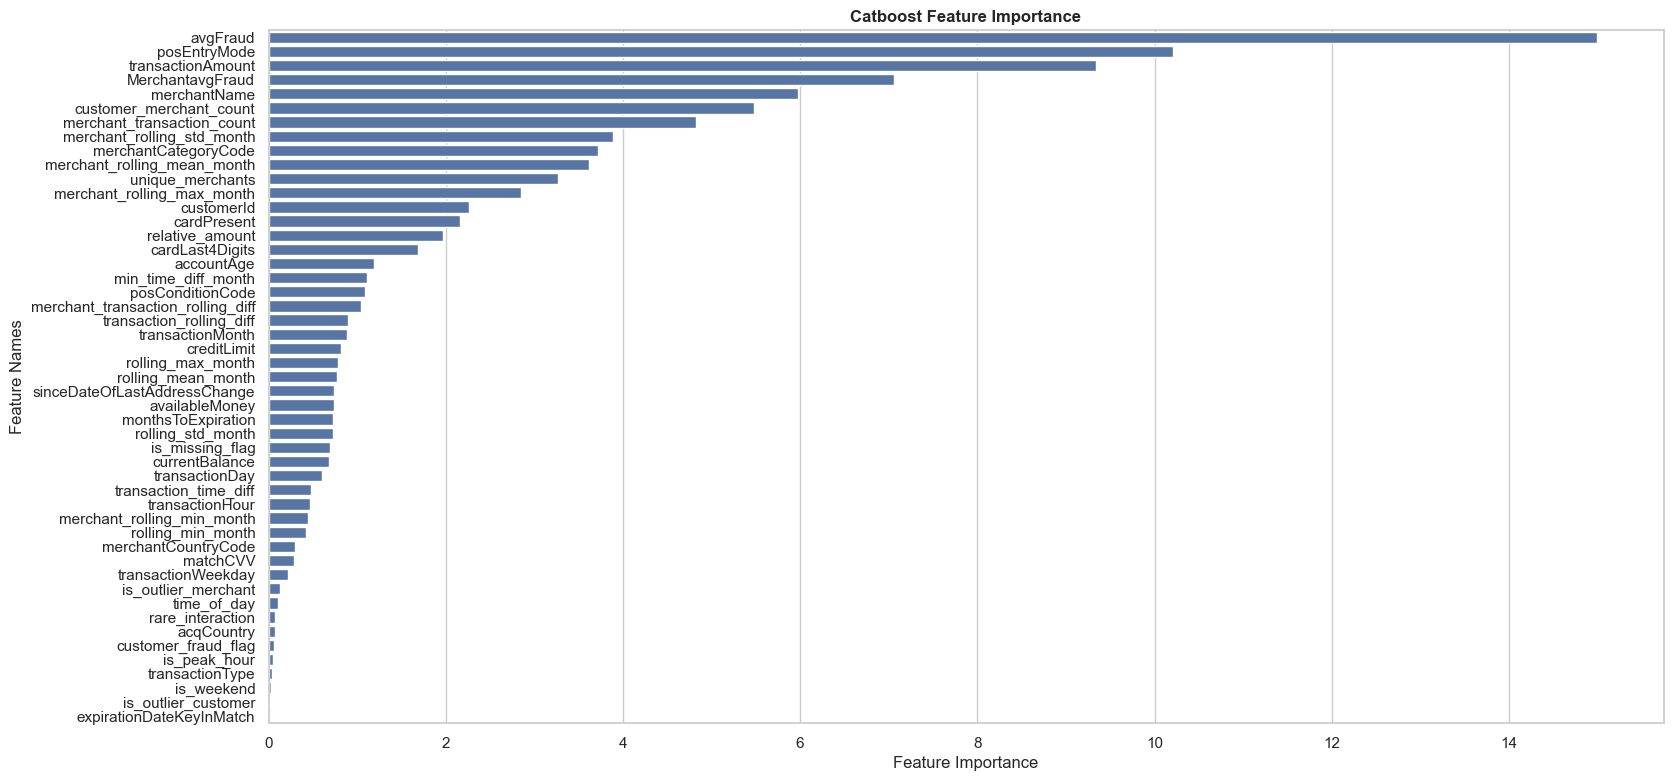

In [42]:
# Visualize model performance
model_performance(y_test, y_proba, threshold=0.5, class_names=['Non Fraud', 'Fraud'])
feature_importance(cat_best_model.feature_importances_,X_train.columns,'Catboost')

## Compare the results of different models

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Info] Number of positive: 9308, number of negative: 46540
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6819
[LightGBM] [Info] Number of data points in the train set: 55848, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

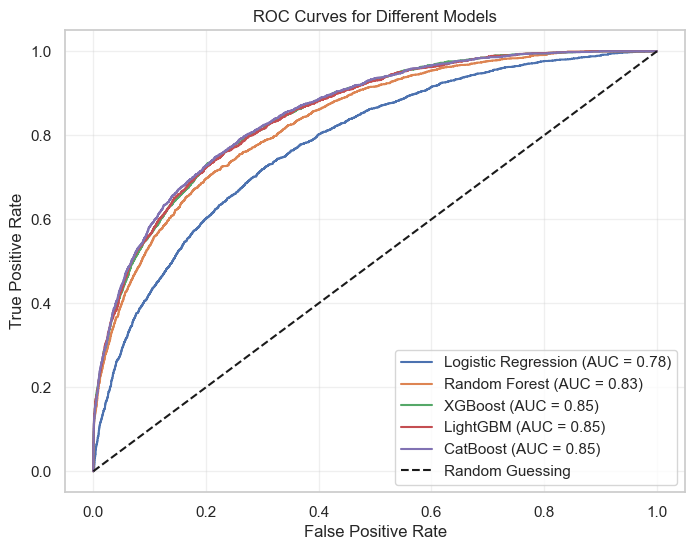

In [43]:
# Initialize models
models = {
    "Logistic Regression": logit_best_model,
    "Random Forest": rf_best_model,
    "XGBoost": xgb_best_model,
    "LightGBM" : lgbm_best_model,
    "CatBoost": cat_best_model
}

# Store results
results = {}

for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    # Predict probabilities for the positive class
    y_proba = model.predict_proba(X_test)[:, 1]
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    # Store results
    results[name] = (fpr, tpr, auc)

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for name, (fpr, tpr, auc) in results.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")

# Add labels, title, and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Models")
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.show()

# Discussion

### Performance

**Our analysis reveals that, overall, boosting methods outperform both Random Forest and Logistic Regression. CatBoost achieves the highest performance, marginally surpassing LightGBM and XGBoost, which exhibit very similar levels of auc scores. CatBoost excels at processing categorical data, and many features in this dataset are categorical. The performance of Random Forest is only slightly lower than that of Boost methods.Logistic Regression ranks lowest among the models tested; however, its performance is not as deficient as initially anticipated. However, the Logistic Regression model is more straightforward and easier for the general public or regulators to grasp.**

### Feature

**Features such as historical fraud ratio, the difference in transaction amounts between two POS entry models, and customer-merchant pair relationships are relatively important, with slight variations across different models. The top features suggest that domain-specific feature engineering (e.g., creating behavior-based and temporal features) plays a significant role in improving the model's performance.

Behavioral patterns, rolling statistics, and historical transaction data are critical for predicting the target variable (likely fraud detection in this context).

In fraud detection scenarios, it makes sense that transaction frequency, amounts, and customer-merchant relationships are highly predictive. These features help identify anomalies that deviate from normal behavior patterns.
**

### Data Leakage

**Data Leakage occurs when information from outside the training dataset is inadvertently used to create the model.**

**Feature Engineering Leakage: Creating features using information from the validation or test sets. Using target-related information in feature creation.**

When constructing statistical and fraud-related features, I always use historical rolling data to prevent future information from leaking into the training data.

**If your data is time series, using standard KFold (default when cv=5) can shuffle data, leading to leakage**

To demonstrate my familiarity with cross-validation, I employed multiple methods; however, I recommend using Time Series Split.

### Overfitting

We used L1 and L2 regularization and limited the max_depth to control overfitting.

### Next steps


Currently, I have chosen a very limited set of parameters for Grid Search and Random Search to reduce the runtime. The next step could involve deploying the script to cloud infrastructure to explore optimal parameters more comprehensively. Additionally, I may consider using SMOTE for oversampling to evaluate whether it improves the results.

### Reference

https://github.com/abdullahsaka/Capital_One-Data_Challenge

https://github.com/jbofill10/C1_Transaction_Data

https://github.com/mandyshen/capital-one-fraud-detection